#  import kit

In [2]:
import re
import math
import cmath
import numpy as np
from numpy.linalg import inv
from array import array
import pylatexenc
import openpyxl
import importlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import pec_module_FID as pec

import qiskit as q
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.visualization import *
from qiskit.quantum_info import Pauli, SparsePauliOp, DensityMatrix, Operator
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import *
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
from qiskit_ibm_runtime import EstimatorV2 as Estimator, SamplerV2 as Sampler, QiskitRuntimeService

In [37]:
importlib.reload(pec)

<module 'pec_module_FID' from '/home/xiaonan/PEC/pec_module_FID.py'>

In [3]:
token = "PJubuPXreZKAxan0yV6OLEIkdKipFYGgvvkGQSZAtpMU"
instance = 'crn:v1:bluemix:public:quantum-computing:us-east:a/f071734952cb4c9993a642d0a87d18bb:392306ae-fe55-475c-a8c5-978d0ba1871e::'
device_name = "kingston"
device = "ibm_" + device_name
device, noise_model, service = pec.load_ibm_backend(token, instance, device)

In [4]:
# # Construct noise model
# noise_model = NoiseModel()

# # Add readout error
# readout_probs = [[0.7, 0.3], [0.2, 0.8]]  # Converting probability to matrix
# readout_error = ReadoutError(readout_probs)
# noise_model.add_readout_error(readout_error, [0])
# noise_model.add_readout_error(readout_error, [1])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
# Get coupling map from backend
coupling_map = device.configuration().coupling_map
# print(len(coupling_map))

backend = AerSimulator(noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates)
# backend = AerSimulator(method = "statevector")
# backend = device
backendqubitNum = backend.num_qubits
print(backendqubitNum)

34


# Fixed parameters

In [ ]:
#520C(1)-10
Gamma_e = 2.8025 #(1/s.T)
Gamma_C13 = 1.0704*10**-3 #(1/s.T)


ti = 0 
tf = 10
itv = 1
tlist = np.arange(ti, tf+itv, itv)

BZ = [0, 50, 100, 200]   #BZ = 0 50 100 200
R = ([np.array([0.07281108260423003, 0.3783374832738622, 0.36039647178489426])])
     # np.array([0.3640554130211498, -0.37833748327386224, -0.20594084101993956]),\
     # np.array([0.5096775782296097, -0.12611249442462072, -0.25742605127492446]),\
     # np.array([-0.5824886608338397, 0, 0.36039647178489426]),\
     # np.array([0.4368664956253798, 0, 0.6178225230598187]),\
     # np.array([0.4368664956253797, 0, -0.6178225230598187]),\
     # np.array([-0.5824886608338398, -0.504449977698483, 0.20594084101993954]),\
     # np.array([0.14562216520845997, -0.7566749665477245, 0.41188168203987907]),\
     # np.array([0.7281108260422997, 0.504449977698483, 0.2059408410199395]),\
     # np.array([0.36405541302114974, 0.8827874609723452, -0.20594084101993962])])#10  #13C的位置向量

#v,c,a用不同QC要改位置
#c、a用array後面的code才不用改
v = 3
c = np.zeros(len(R))
c = c.astype(int)
for i in range (len(c)):
    c[i] = i + 1+3
a = np.zeros(len(c))
a = a.astype(int)
for i in range (len(c)):
    a[i] = i + len(c) + 1+3

bits_len = max(v, max(max(c), max(a))) + 1


array([5])

# Calculate Readout PEC Observable

In [59]:
device_qubits = backendqubitNum
qubit_numbers = len(c)
initial_circuits_v = pec.build_initial_states(v)
measurements = pec.build_measurement_pauli(v, observable_number=backendqubitNum)
job = pec.run_measurements(initial_circuits_v, measurements, backend, shots=10000)
g_matrix = pec.collect_results(job, qubit_numbers)
A_matrix = pec.get_preparation_matrix(qubit_numbers)
B_matrix, noisy_coefficient = pec.build_corrected_observables(g_matrix, A_matrix, qubit_numbers)
ideal_measurements = pec.build_ideal_measurement(noisy_coefficient, qubit_numbers, device_qubits)
ideal_measurements

{'measI': SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
               coeffs=[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]),
 'measX': SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
               coeffs=[ 0.00493286+0.j,  1.00667388+0.j, -0.01683501+0.j,  0.00162439+0.j]),
 'measY': SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
               coeffs=[ 1.75566327e-05+0.j,  3.70385723e-03+0.j,  1.01159126e+00+0.j,
  -5.92267708e-03+0.j]),
 'measZ': SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIY', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZ'],
               coeffs=[ 6.9

In [60]:
B_matrix

array([[ 1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00],
       [-4.900e-03,  9.933e-01,  1.650e-02, -1.500e-03],
       [ 0.000e+00, -3.600e-03,  9.886e-01,  5.800e-03],
       [-1.000e-04,  6.300e-03,  2.030e-02,  9.897e-01]])

# Calculate CNOT PEC Weight

In [61]:
initial_circuits_c = {f'q{qc}':pec.build_initial_states(qc) for qc in c}
initial_circuits_vc = {qc:pec.combine_state(init_cir_c, initial_circuits_v) for qc, init_cir_c in initial_circuits_c.items()}
measurements_cnot = {f'q{qc}':pec.build_measurement_pauli(v, qc, observable_number=backendqubitNum) for qc in c}


In [62]:
print(measurements)
print(g_matrix)

{'measI': [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII')], 'measX': [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIXIII')], 'measY': [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIYIII')], 'measZ': [Pauli('IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIII')]}
[[ 1.      1.      1.      1.    ]
 [-0.0064 -0.0034  0.9884  0.0116]
 [ 0.0058 -0.0058 -0.0036  0.9886]
 [ 0.9896 -0.9898  0.0062  0.0202]]


# parameters

In [63]:
def normalize(h): 
    a = h / np.sqrt(np.sum(h**2))
    return a

def A_z(h):
    n = 0.0198763
    d = (np.sqrt(np.sum(h**2)))**3
    a_x = (n/d)*(-3)*normalize(h)[2]*normalize(h)[0]
    a_y = (n/d)*(-3)*normalize(h)[2]*normalize(h)[1]
    a_z = (n/d)*(1-3*normalize(h)[2]**2)

    return np.array([a_x, a_y, a_z])

R_z = np.zeros([len(BZ),len(tlist)]) 
theta = np.zeros([len(BZ),len(R),len(tlist)])
phi = np.zeros([len(BZ),len(R),len(tlist)])
Lambda = np.zeros([len(BZ),len(R),len(tlist)])
gamma = np.zeros([len(BZ),len(R),len(tlist)])

for bz in range(len(BZ)):
    omega_0 = (0,0,Gamma_C13*BZ[bz])
    for i in range(len(tlist)):         
        for r in range(len(R)):
            omega_1 = np.array([A_z(R[r])[0],A_z(R[r])[1],A_z(R[r])[2]+Gamma_C13*BZ[bz]])
            
            normalized_omega1 = normalize(omega_1)

            R_z[bz][i] = 2*np.pi*omega_0[2]*(itv*i+ti)

            theta[bz][r][i] = (2*math.asin(math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2) *np.sqrt(normalized_omega1[0]**2 + normalized_omega1[1]**2)))

            phi[bz][r][i] = ((-np.pi)/2
            +cmath.polar(complex(normalized_omega1[0],normalized_omega1[1]))[1]
            - cmath.polar(
                complex(
                    math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                    -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])

            Lambda[bz][r][i] = ((np.pi)/2
            -cmath.polar(complex(normalized_omega1[0],normalized_omega1[1]))[1]
            - 2*np.pi*Gamma_C13*BZ[bz]*(itv*i+ti)
            - cmath.polar(
                complex(
                    math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                    -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])

            gamma[bz][r][i] =((2*np.pi*Gamma_C13*BZ[bz]*(itv*i+ti))/2
            +cmath.polar(complex(
                    math.cos((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2),
                    -math.sin((2*np.pi*np.linalg.norm(omega_1)*(itv*i+ti))/2)*normalized_omega1[2]))[1])

In [64]:
#根據v,c,a的位置設定qubit的位元
qreg = QuantumRegister(bits_len, 'q')
creg = ClassicalRegister(bits_len, 'c')

qcl = {}
for bz in range(len(BZ)):
    qcir = []    
    for i in range (len(tlist)):
        #IBM空白的電路圖
        circuit = QuantumCircuit(qreg, creg)

        #State preparation & polarization
        circuit.h(v)
        for j in range (len(c)):
            circuit.h(c[j])
            circuit.cx(c[j], a[j])
            # circuit.u((np.pi)/2, 0, 0, c[j])

        #FID
        for j in range (len(c)):
            circuit.rz(R_z[bz][i], c[j])
            circuit.cu(theta[bz][j][i], phi[bz][j][i], Lambda[bz][j][i], gamma[bz][j][i], v, c[j])
        qcir.append(circuit)
    qcl.update({f'{BZ[bz]}':qcir})

In [65]:
qcl['50']

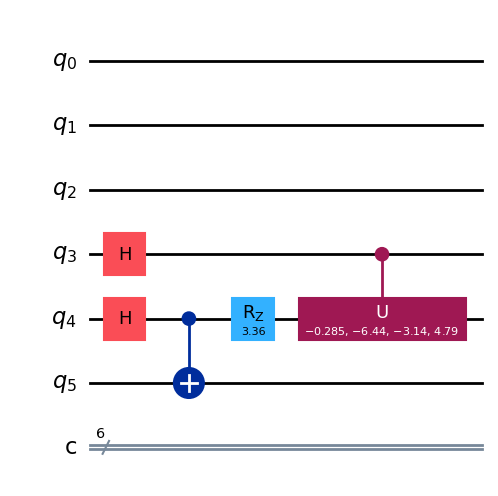

In [66]:
display(qcl['100'][5].draw(output='mpl'))

In [67]:
shots = 1024
estimator = Estimator(mode=backend)

jobX_N = {}
jobY_N = {}
jobX_M = {}
jobY_M = {}
for Bz, circuit_set in qcl.items():
    batchedX_N = []
    batchedY_N = []
    batchedX_M = []
    batchedY_M = []
    for cir in circuit_set:
        CirTran = q.compiler.transpile(cir, backend=backend, optimization_level=0)
        batchedX_N.append((CirTran, measurements['measX']))
        batchedY_N.append((CirTran, measurements['measY']))
        batchedX_M.append((CirTran, ideal_measurements['measX']))
        batchedY_M.append((CirTran, ideal_measurements['measY']))
    jobX_N.update({Bz:estimator.run(batchedX_N)})
    jobY_N.update({Bz:estimator.run(batchedY_N)})
    jobX_M.update({Bz:estimator.run(batchedX_M)})
    jobY_M.update({Bz:estimator.run(batchedY_M)})
    

In [68]:
def get_expectation(job):
    expectation = {}
    for Bz, jb in job.items():
        result = jb.result()
        expct = [res.data.evs for res in result]
        expectation.update({Bz:expct})
    return expectation   

expctX_N = get_expectation(jobX_N)
expctY_N = get_expectation(jobY_N)
expctX_M = get_expectation(jobX_M)
expctY_M = get_expectation(jobY_M)

print(expctX_N)

{'0': [array([0.97949219]), array([0.77441406]), array([0.25683594]), array([-0.38427734]), array([-0.86376953]), array([-0.97167969]), array([-0.65869141]), array([-0.08642578]), array([0.52978516]), array([0.91601562]), array([0.93994141])], '50': [array([0.97802734]), array([0.76953125]), array([0.28613281]), array([-0.31445312]), array([-0.64990234]), array([-0.65820312]), array([-0.40820312]), array([-0.07226562]), array([0.07958984]), array([0.0546875]), array([-0.10693359])], '100': [array([0.984375]), array([0.765625]), array([0.34130859]), array([-0.00878906]), array([-0.09472656]), array([0.05664062]), array([0.13476562]), array([-0.11572266]), array([-0.5703125]), array([-0.92871094]), array([-0.93066406])], '200': [array([0.98046875]), array([0.82275391]), array([0.57177734]), array([0.67822266]), array([0.85839844]), array([0.67382812]), array([0.38476562]), array([0.35742188]), array([0.51171875]), array([0.37744141]), array([0.02783203])]}


In [69]:
def graphdata(expectation, time):
    for Bz, expct in expectation.items():
        print("Bz = ", Bz, ':')
        for t, e in zip(time, expct):        
            print(f"{{{t}, {e.item()}}}", ",")
    print('\n')


graphdata(expctX_N, tlist)
graphdata(expctY_N, tlist)
graphdata(expctX_M, tlist)
graphdata(expctY_M, tlist)

Bz =  0 :
{0, 0.9794921875} ,
{1, 0.7744140625} ,
{2, 0.2568359375} ,
{3, -0.38427734375} ,
{4, -0.86376953125} ,
{5, -0.9716796875} ,
{6, -0.65869140625} ,
{7, -0.08642578125} ,
{8, 0.52978515625} ,
{9, 0.916015625} ,
{10, 0.93994140625} ,
Bz =  50 :
{0, 0.97802734375} ,
{1, 0.76953125} ,
{2, 0.2861328125} ,
{3, -0.314453125} ,
{4, -0.64990234375} ,
{5, -0.658203125} ,
{6, -0.408203125} ,
{7, -0.072265625} ,
{8, 0.07958984375} ,
{9, 0.0546875} ,
{10, -0.10693359375} ,
Bz =  100 :
{0, 0.984375} ,
{1, 0.765625} ,
{2, 0.34130859375} ,
{3, -0.0087890625} ,
{4, -0.0947265625} ,
{5, 0.056640625} ,
{6, 0.134765625} ,
{7, -0.11572265625} ,
{8, -0.5703125} ,
{9, -0.9287109375} ,
{10, -0.9306640625} ,
Bz =  200 :
{0, 0.98046875} ,
{1, 0.82275390625} ,
{2, 0.57177734375} ,
{3, 0.67822265625} ,
{4, 0.8583984375} ,
{5, 0.673828125} ,
{6, 0.384765625} ,
{7, 0.357421875} ,
{8, 0.51171875} ,
{9, 0.37744140625} ,
{10, 0.02783203125} ,


Bz =  0 :
{0, -0.00390625} ,
{1, 0.0009765625} ,
{2, -0.044921875